# Imports

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
#CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/Text_Mining_Project_Amazon/")
!pwd

/content/drive/MyDrive/Text_Mining_Project_Amazon


In [ ]:
df = pd.read_csv("AmazonFinal_general.csv")

In [ ]:
conditions = [
    (df['Score'] <= 3),
    (df['Score'] >= 4)
    ]
values = [ 'Negative' , 'Positive']
df['Polarity'] = np.select(conditions, values)

In [ ]:
df.Polarity.unique()

array(['Positive', 'Negative'], dtype=object)

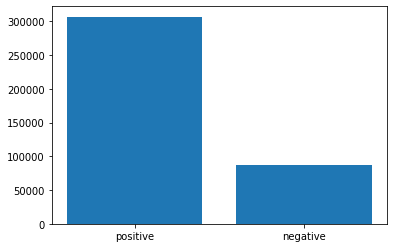

In [ ]:
classes = df.Polarity.unique()
counts = []

for i in classes:
  count = len(df[df.Polarity==i])
  counts.append(count)

plt.bar(['positive', 'negative'], counts)
plt.show()

In [ ]:
for i in classes:
  count = len(df[df.Polarity==i])
  print(count)

306887
86848


In [ ]:
#df.loc[df['Polarity'] == 'positive']

positive = df.loc[df['Polarity'] == 'Positive']
negative = df.loc[df['Polarity'] == 'Negative']

In [ ]:
positive = positive.sample(n = 86848)

In [ ]:
frames = [positive, negative]
result = pd.concat(frames)

In [ ]:
df = result
df.columns

Index(['Text', 'Summary', 'Score', 'Polarity'], dtype='object')

In [ ]:
df.shape

(173696, 4)

## Train/test split

We use the hole sample and then split taht into 80% for training and 20% for testing.

In [ ]:
x = df.Text.values
y = df.Polarity.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

# Vectorize
What we need to do now is to split the data into training and testing datasets and vectorize (essentialy turning text into number vectors) the text. We use two different approaches for weigthing words

Vectorizing

In [ ]:
vectorizer = CountVectorizer() 
vectorizer_tfidf = TfidfVectorizer()  

vectorizer.fit(x_train)
vectorizer_tfidf.fit(x_train)

TfidfVectorizer()

In [ ]:


X_train_tfidf = vectorizer_tfidf.transform(x_train)  #fit_transform_tfidf
X_test_tfidf = vectorizer_tfidf.transform(x_test)

X_train = vectorizer.transform(x_train)  #fit_transform
X_test = vectorizer.transform(x_test)

Our vectorized dataset will consist of index of each word that is used in training dataset. We can check how it looks by simply printing the first text both as it was and after vectorizing it.

In [ ]:
print(x_train[0], '\n', X_train[0])

nice seasoning use anything think ofbr try 
   (0, 4144)	1
  (0, 69821)	1
  (0, 72421)	1
  (0, 91691)	1
  (0, 105611)	1
  (0, 108680)	1
  (0, 111299)	1


In [ ]:
 print(x_train[0], '\n', X_train_tfidf[0])

nice seasoning use anything think ofbr try 
   (0, 111299)	0.24779815373399453
  (0, 108680)	0.2517664487500247
  (0, 105611)	0.2727154978846611
  (0, 91691)	0.4504582655609501
  (0, 72421)	0.6327677583410412
  (0, 69821)	0.29875114049344775
  (0, 4144)	0.32905327615613367


In [ ]:
x_train.dtype, X_train_tfidf.dtype

(dtype('O'), dtype('float64'))

Now the sparse matrix you see corresponds to index of the word and count of it in the review text. it's not in the same order as in the review text. 

# Modelling
The model that we use here is a simple Logistic Regression. 

In [ ]:
classifier = LogisticRegression(max_iter=1000)

classifier_tfidf  = LogisticRegression(max_iter=1000)

classifier.fit(X_train_tfidf, y_train)

score = classifier.score(X_test, y_test)


# _tfidf X_test_tfidf

classifier_tfidf.fit(X_train_tfidf, y_train)

score_tfidf = classifier_tfidf.score(X_test_tfidf, y_test)



print("Accuracy:", score, score_tfidf)

Accuracy: 0.8310592976396085 0.8513241220495107


#Confussion matrix
 we can use confusion matrix.
It essentially shows how many times model predicted which class and how many of those times the class it slected was the right one. Here columns are true values and lines are predicted values.

In [ ]:
y_pred = classifier_tfidf.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=df.Polarity.unique())
df_cm = pd.DataFrame(cm, index=df.Polarity.unique(), columns=df.Polarity.unique())
df_cm

,Positive,Negative
Positive,14679,2585
Negative,2580,14896


For a better understanding you could use percentage expression.

In [ ]:
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,Positive,Negative
Positive,0.850513,0.147875
Negative,0.149487,0.852125


# Test

Now we need to check if it actually works. Let's manually create a review

In [ ]:
text = 'find barilla pasta really good italy is perfect match for fine food'
vectText = vectorizer.transform(np.array([text]))  # vectorizes the text using our vectorizer

prediction = classifier.predict(vectText)  # predicts class of the text
print('Text is', 'positive' if prediction[0]=='Positive' else 'negative')

Text is positive


In [ ]:
textList = ['barilla pasta really good', 'this barilla pasta sucks bad'] 
vectText = vectorizer.transform(np.array(textList)) # vectorizes the text using our vectorizer

prediction = classifier.predict(vectText) # predicts class of the text
for enum, i in enumerate(textList): 
  print(i, '| This text is', 'positive' if prediction[enum]=='Positive' else 'negative')


barilla pasta really good | This text is positive
this barilla pasta sucks bad | This text is negative
